# FCFS-Scheduling

> FCFS (First‐Come‐First‐Served) ist eine Scheduling‐Strategie, bei der Operationen strikt in der Reihenfolge ihres frühestmöglichen Starts – basierend auf der Ankunftszeit des Jobs und der Maschinenfreigabe – abgearbeitet werden. 


In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

In [2]:
import json
import pandas as pd
from collections import defaultdict

In [7]:
basic_data_path = get_path("data", "basic")

In [8]:
# Datei laden
file_path = basic_data_path / "jobshop_instances.json"

with open(file_path, "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


**FCFS-Scheduling Algorithmus**

1. **Initialisierung**:

   * Setze Startzeit jedes Jobs (`job_ready`) und Maschinenverfügbarkeit (`machine_ready`) auf 0.
   * Setze die nächste einzuplanende Operation jedes Jobs auf `Operation 0`.

2. **Solange noch nicht alle Operationen eingeplant sind**:

   1. Durchlaufe alle Jobs:

      * Ermittle für jede noch nicht geplante Operation die **frühestmögliche Startzeit**, basierend auf:

        * dem frühesten Abschluss der vorherigen Operation des Jobs,
        * der Verfügbarkeit der zugehörigen Maschine.
   2. Wähle unter allen betrachtbaren Jobs die **Operation mit dem kleinsten frühestmöglichen Startzeitpunkt**.

      * Bei Gleichstand: wähle den Job mit der kleineren ID.
   3. **Plane diese Operation ein**:

      * Weise ihr Start- und Endzeit zu.
      * Aktualisiere Maschinenverfügbarkeit und Jobstatus.
      * Erhöhe den Index der nächsten Operation für diesen Job.

3. **Wiederholen**, bis alle Operationen eingeplant sind.



> Dieser FCFS-Algorithmus löst Maschinenkonflikte **implizit** durch Reihenfolge im Schleifendurchlauf


In [9]:
def schedule_fcfs(df_jssp: pd.DataFrame) -> pd.DataFrame:
    """
    FCFS-Scheduling ohne Ankunftszeiten auf Basis eines DataFrames.
    """
    next_op = {job: 0 for job in df_jssp['Job'].unique()}
    job_ready = {job: 0.0 for job in df_jssp['Job'].unique()}
    machine_ready = defaultdict(float)
    remaining = len(df_jssp)

    schedule = []

    while remaining > 0:
        best = None

        for job, op_idx in next_op.items():
            if op_idx >= (df_jssp['Job'] == job).sum():
                continue
            row = df_jssp[(df_jssp['Job'] == job) & (df_jssp['Operation'] == op_idx)].iloc[0]
            m = int(row['Machine'].lstrip('M'))
            dur = row['Processing Time']
            earliest = max(job_ready[job], machine_ready[m])
            if (best is None or
                earliest < best[1] or
                (earliest == best[1] and job < best[0])):
                best = (job, earliest, dur, m, op_idx)

        job, start, dur, m, op_idx = best
        end = start + dur
        schedule.append({
            'Job': job,
            'Operation': op_idx,
            'Machine': f'M{m}',
            'Start': start,
            'Processing Time': dur,
            'End': end
        })

        job_ready[job] = end
        machine_ready[m] = end
        next_op[job] += 1
        remaining -= 1

    df_schedule = pd.DataFrame(schedule).sort_values(['Job', 'Start'])
    makespan = df_schedule['End'].max()
    print("\nPlan-Informationen:")
    print(f"  Makespan: {makespan}")
    return df_schedule




In [10]:
df_plan = schedule_fcfs(df_instance)
df_plan


Plan-Informationen:
  Makespan: 1262.0


,Job,Operation,Machine,Start,Processing Time,End
0,job 0,0,M0,0.0,29,29.0
7,job 0,1,M1,91.0,78,169.0
11,job 0,2,M2,188.0,9,197.0
13,job 0,3,M3,197.0,36,233.0
19,job 0,4,M4,263.0,49,312.0
...,...,...,...,...,...,...
90,job 9,5,M9,952.0,76,1028.0
94,job 9,6,M5,1028.0,47,1075.0
95,job 9,7,M3,1075.0,52,1127.0
98,job 9,8,M4,1127.0,90,1217.0


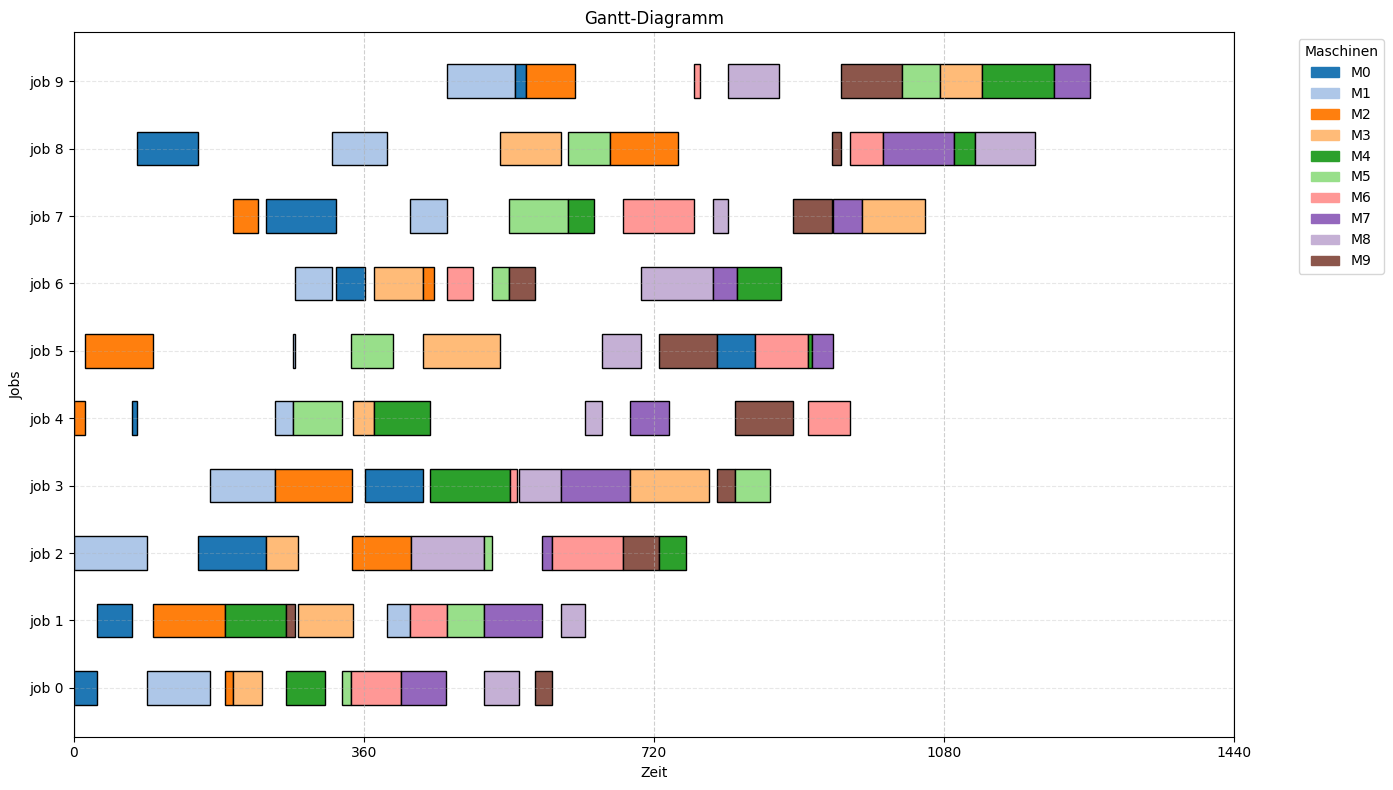

In [11]:
show.plot_gantt_jobs(df_plan)

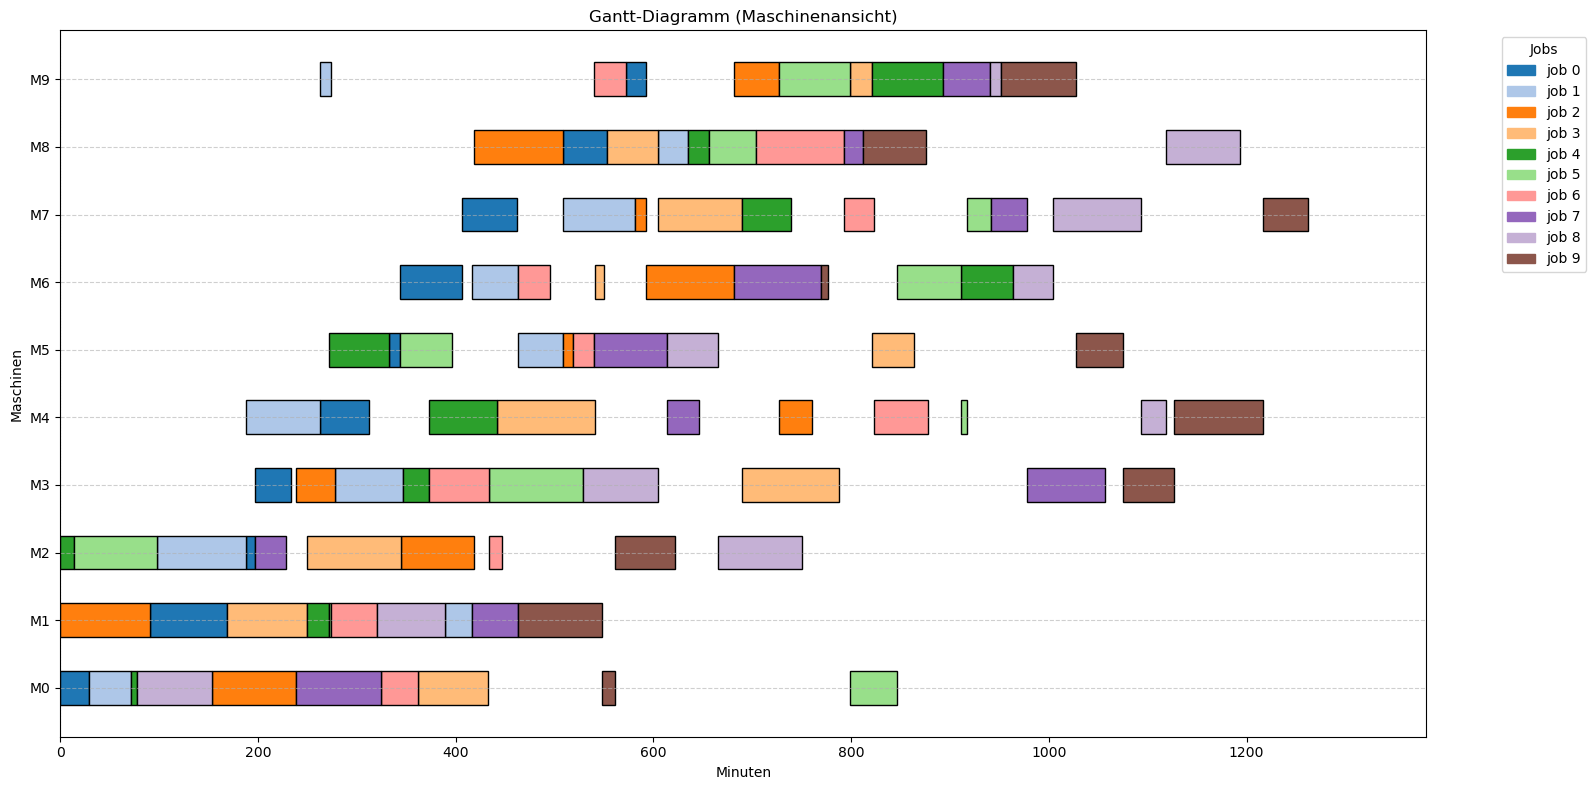

In [8]:
show.plot_gantt_machines(df_plan)

In [9]:
check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.


True